In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from sklearn.linear_model import LinearRegression

from statsmodels.tools.sm_exceptions import ConvergenceWarning
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
%pip install bayesian-optimization

from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import numpy as np

Note: you may need to restart the kernel to use updated packages.


Generate Sample Daily Temperature Data

In [2]:
df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")
display(df_lagged.head(3))


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


Function to Generate Temperature Features

In [3]:
# def create_lagged_features(series, lag=6):
#     """Create lagged features using past temperature values."""
#     feature_set = []
#     target_values = []

#     for i in range(lag, len(series)):
#         feature_set.append(series[i - lag:i])
#         target_values.append(series[i])

#     return np.array(feature_set), np.array(target_values)


Helper Functions



In [9]:
df_lagged_train = df_lagged.iloc[:150]
df_lagged_test = df_lagged.iloc[150:]

# display(df_lagged_train.head(3))
# display(df_lagged_test.head(3))

# Helper to extract lagged features and target from df_lagged

def create_lagged_features(df, lag=6):
    lag_cols = [f'TVV_Lag{i}' for i in range(1, lag+1)]
    X = df[lag_cols].values
    y = df['Totaal_verkochte_wegvoertuigen'].values
    return X, y

# Update prepare_features to use DataFrame

def prepare_features(data, lag):
    return create_lagged_features(data, lag)

def train_modellr(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model
    
def train_modelxgb(X_train, y_train):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    return model

def make_predictions(model, X_test):
    return model.predict(X_test)

def calculate_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def plot_results(dates, actual_values, predicted_values, lag):
    start_index = lag + len(dates) - len(actual_values)
    prediction_dates = dates[start_index:]

    # Align lengths
    if len(prediction_dates) > len(actual_values):
        prediction_dates = prediction_dates[:len(actual_values)]
    elif len(actual_values) > len(prediction_dates):
        actual_values = actual_values[:len(prediction_dates)]
        predicted_values = predicted_values[:len(prediction_dates)]

    plt.figure(figsize=(12, 6))
    plt.plot(prediction_dates, actual_values, label="Actual Temperatures", alpha=0.7)
    plt.plot(prediction_dates, predicted_values, label="Predicted Temperatures", alpha=0.7)
    plt.title("Walk-Forward Validation for Temperature Prediction")
    plt.xlabel("Date")
    plt.ylabel("sold vehicles")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Walk-Forward Validation

In [5]:
def perform_walk_forward_validation(temperature_series, training_window=90, forecast_horizon=30, lag=6):
    mean_squared_errors = []
    all_predictions = []
    all_actuals = []

    for start in range(0, len(temperature_series) - training_window - forecast_horizon, forecast_horizon):
        training_data, testing_data = split_data(temperature_series, start, training_window, forecast_horizon)
        X_train, y_train = prepare_features(training_data, lag)
        X_test, y_test = prepare_features(testing_data, lag)

        model = train_modellr(X_train, y_train)
        test_predictions = make_predictions(model, X_test)
        mse = calculate_error(y_test, test_predictions)

        mean_squared_errors.append(mse)
        all_predictions.extend(test_predictions)
        all_actuals.extend(y_test)

    return mean_squared_errors, all_predictions, all_actuals


In [6]:
def perform_walk_forward_validation(temperature_series, training_window=90, forecast_horizon=30, lag=6):
    mean_squared_errors = []
    all_predictions = []
    all_actuals = []

    for start in range(0, len(temperature_series) - training_window - forecast_horizon, forecast_horizon):
        training_data, testing_data = split_data(temperature_series, start, training_window, forecast_horizon)
        X_train, y_train = prepare_features(training_data, lag)
        X_test, y_test = prepare_features(testing_data, lag)

        model = train_modelxgb(X_train, y_train)
        test_predictions = make_predictions(model, X_test)
        mse = calculate_error(y_test, test_predictions)

        mean_squared_errors.append(mse)
        all_predictions.extend(test_predictions)
        all_actuals.extend(y_test)

    return mean_squared_errors, all_predictions, all_actuals


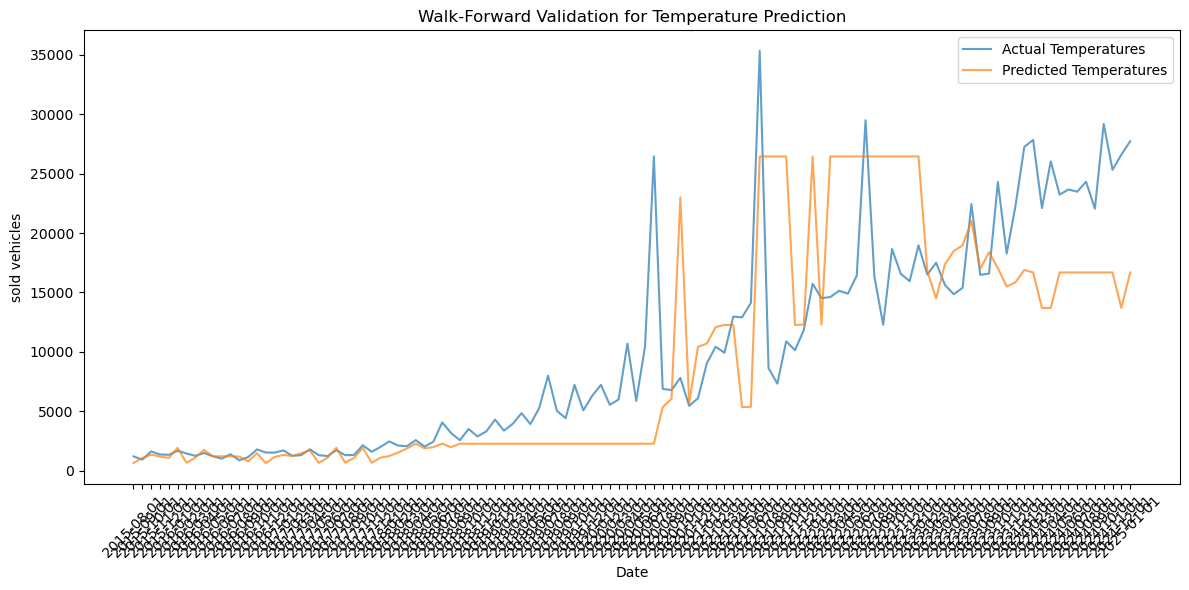

MAPE: 0.4177
MAE: 4874.8699
RMSE: 7380.7570
R2: 0.4264


In [10]:
from sklearn.metrics import mean_absolute_percentage_error

def split_data(df, start, training_window, forecast_horizon):
    """
    Splits the dataframe into training and testing sets for walk-forward validation.
    """
    train = df.iloc[start : start + training_window]
    test = df.iloc[start + training_window : start + training_window + forecast_horizon]
    return train, test

# Run the Walk-Forward Validation Process
_, predicted_temperatures, actual_temperatures = perform_walk_forward_validation(
    df_lagged, training_window=90, forecast_horizon=30, lag=6
)

# Plot the Predicted vs Actual Temperatures
plot_results(
    df_lagged["Periode"], actual_temperatures, predicted_temperatures, lag=6
)

mae = mean_absolute_error(actual_temperatures, predicted_temperatures)
rmse = np.sqrt(mean_squared_error(actual_temperatures, predicted_temperatures))
r2 = r2_score(actual_temperatures, predicted_temperatures)
mape = mean_absolute_percentage_error(actual_temperatures, predicted_temperatures)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


Run and Plot

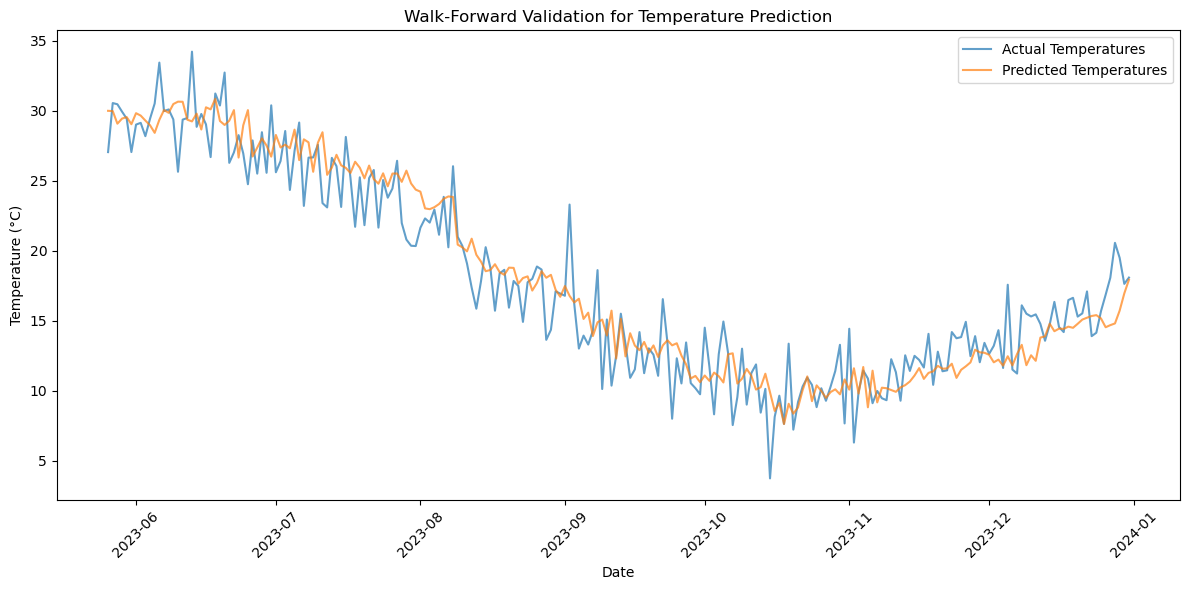

MAPE: 0.1181
MAE: 1.7563
RMSE: 2.3195
R2: 0.8899


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Run the Walk-Forward Validation Process for Totaal_verkochte_wegvoertuigen
_, predicted, actual = perform_walk_forward_validation(df_lagged, training_window=90, forecast_horizon=30, lag=6)

# Plot the Predicted vs Actual Values
plot_results(
    df_lagged['Periode'], actual, predicted, lag=6
)

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


MAPE: 0.3275
MAE: 5556.4878
RMSE: 7697.9470
R2: -0.1344


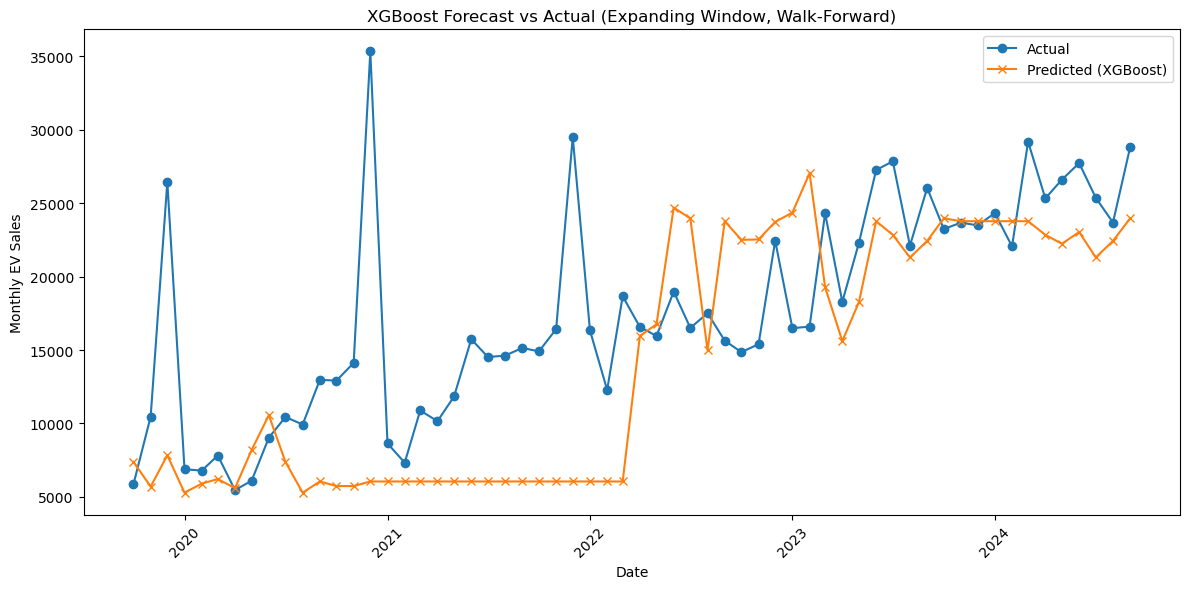

In [12]:

from sklearn.metrics import mean_absolute_percentage_error

def split_data_expanding(df, initial_train_size, forecast_horizon, step_size=1):
    """
    Generator for expanding window splits for walk-forward validation.
    Yields (train, test) DataFrames.
    """
    n = len(df)
    for i in range(initial_train_size, n - forecast_horizon + 1, step_size):
        train = df.iloc[:i]
        test = df.iloc[i:i + forecast_horizon]
        yield train, test

# Example usage for XGBoost (can be adapted for other models)
initial_train_size = int(len(df_lagged) * 0.7)
forecast_horizon = 30
step_size = forecast_horizon  # or 1 for more granular

X_cols = [f'TVV_Lag{i}' for i in range(1, 7)]
y_col = 'Totaal_verkochte_wegvoertuigen'

predictions = []
actuals = []
test_periods = []

for train, test in split_data_expanding(df_lagged, initial_train_size, forecast_horizon, step_size):
    X_train, y_train = train[X_cols].values, train[y_col].values
    X_test, y_test = test[X_cols].values, test[y_col].values

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.extend(y_pred)
    actuals.extend(y_test)
    test_periods.extend(test['Periode'])

predictions = np.array(predictions)
actuals = np.array(actuals)

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = mean_absolute_percentage_error(actuals, predictions)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(test_periods), actuals, label='Actual', marker='o')
plt.plot(pd.to_datetime(test_periods), predictions, label='Predicted (XGBoost)', marker='x')
plt.title('XGBoost Forecast vs Actual (Expanding Window, Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Features Used and Model Performance Explanation

**Features used in the current XGBoost expanding window walk-forward:**
- TVV_Lag1
- TVV_Lag2
- TVV_Lag3
- TVV_Lag4
- TVV_Lag5
- TVV_Lag6

These are only lagged values of the target (Totaal_verkochte_wegvoertuigen). No exogenous variables (macroeconomic, trends, etc.) are included.

**Why are results poor?**
- Lag-only models cannot anticipate sudden spikes, drops, or external influences.
- The sales series is volatile and likely driven by more than just its own history.
- XGBoost default hyperparameters may not be optimal.
- Adding more features (all available columns except the target and date) and tuning hyperparameters will likely improve results.

**Next steps:**
- Try using all features for XGBoost.
- Tune hyperparameters.
- Consider adding calendar and external variables.

MAPE (all features): 0.2915
MAE (all features): 6001.0054
RMSE (all features): 8094.9231
R2 (all features): -0.2544


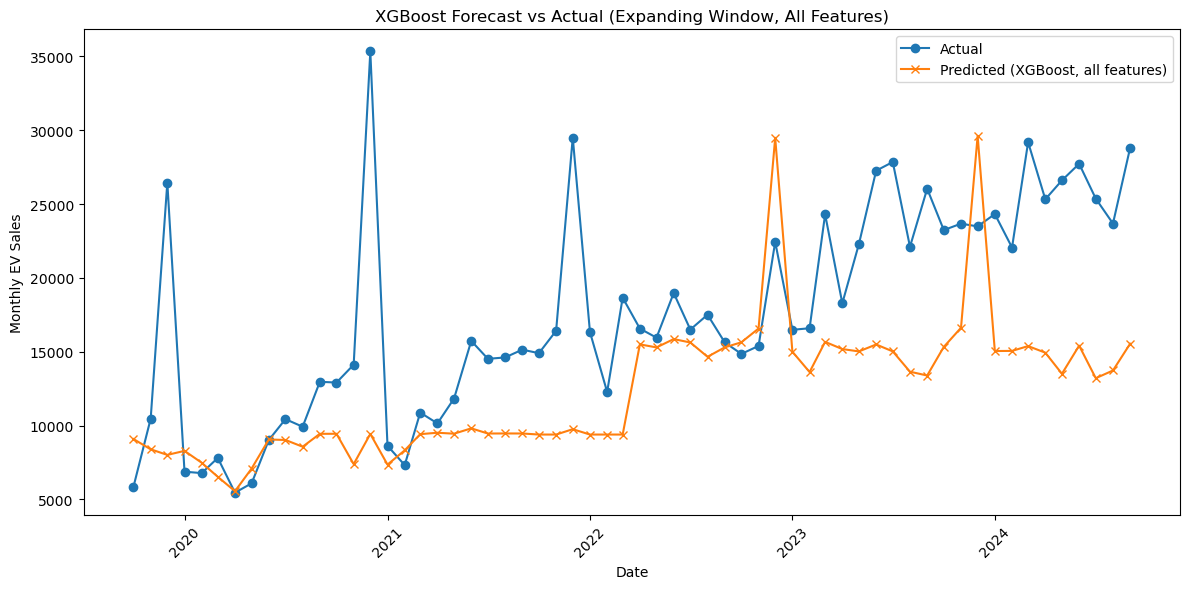

In [13]:
# Select all features except the target and date columns
date_col = 'Periode'
target_col = 'Totaal_verkochte_wegvoertuigen'
all_feature_cols = [col for col in df_lagged.columns if col not in [date_col, target_col]]

initial_train_size = int(len(df_lagged) * 0.7)
forecast_horizon = 30
step_size = forecast_horizon  # or 1 for more granular

predictions_all = []
actuals_all = []
test_periods_all = []

for train, test in split_data_expanding(df_lagged, initial_train_size, forecast_horizon, step_size):
    X_train, y_train = train[all_feature_cols].values, train[target_col].values
    X_test, y_test = test[all_feature_cols].values, test[target_col].values

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions_all.extend(y_pred)
    actuals_all.extend(y_test)
    test_periods_all.extend(test[date_col])

predictions_all = np.array(predictions_all)
actuals_all = np.array(actuals_all)

mae_all = mean_absolute_error(actuals_all, predictions_all)
rmse_all = np.sqrt(mean_squared_error(actuals_all, predictions_all))
r2_all = r2_score(actuals_all, predictions_all)
mape_all = mean_absolute_percentage_error(actuals_all, predictions_all)

print(f"MAPE (all features): {mape_all:.4f}")
print(f"MAE (all features): {mae_all:.4f}")
print(f"RMSE (all features): {rmse_all:.4f}")
print(f"R2 (all features): {r2_all:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(test_periods_all), actuals_all, label='Actual', marker='o')
plt.plot(pd.to_datetime(test_periods_all), predictions_all, label='Predicted (XGBoost, all features)', marker='x')
plt.title('XGBoost Forecast vs Actual (Expanding Window, All Features)')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Note:**
- All features except the target and date columns are used as predictors.
- This approach should capture more information and may improve model performance compared to lag-only features.
- Next steps: consider feature selection, hyperparameter tuning, and adding external/calendar variables for further improvement.